In [549]:
%matplotlib inline
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from Tree import Tree, Node

import sys  
sys.path.insert(0, '../notebooks/')
from utils import calc_cost, plot_kmeans, plot_tree_boundary

/Users/lucasmurtinho/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass centers=3, cluster_std=2.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


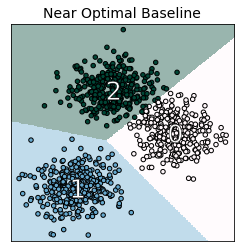

In [550]:
n = 1000
d = 2
k = 3
x_data, _ = make_blobs(n, d, k, 2.5, random_state=42)



kmeans = KMeans(k, random_state=42)
kmeans.fit(x_data)

plot_kmeans(kmeans, x_data)

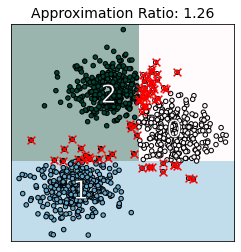

In [691]:
tree_1k = Tree(k)
tree_1k.fit(x_data, kmeans)

plot_tree_boundary(tree_1k, k, x_data, kmeans, plot_mistakes=True)

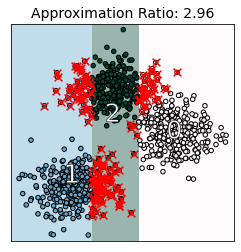

In [677]:
tree_0d = Tree(k, valid_col_idx=[0])
tree_0d.fit(x_data, kmeans)

plot_tree_boundary(tree_0d, k, x_data, kmeans, plot_mistakes=True)

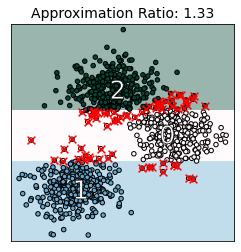

In [556]:
tree_1d = Tree(k, valid_col_idx=[1])
tree_1d.fit(x_data, kmeans)

plot_tree_boundary(tree_1d, k, x_data, kmeans, plot_mistakes=True)

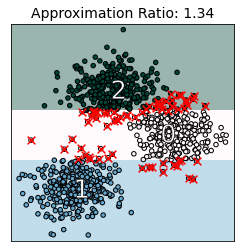

In [675]:
tree_char1 = Tree(k, valid_col_idx=[1])
tree_char1.tree = tree_c1
plot_tree_boundary(tree_char1, k, x_data, kmeans, plot_mistakes=True)

[-6.84696555 -2.59881762  4.84710315] [-4.72289158  1.12414276]
infos: [3.15 1.  ] 1 0 0 2 1.0
idx_mask: [1]
M: [1.]
initial x_idx: 1
result: 1 1.0

infos: [3.15] 1 0 0 2 1.0
idx_mask: [0]
M: [3.15]
initial x_idx: 0
result: 0 3.15

infos: [] 1 0 0 2 1.0

infos: [] 1 0 0 2 1.0

infos: [] 1 0 0 2 1.0

0 -1 1 1.0
1 0 0 3.15
2 0 None None
3 1 None None
4 1 None None

0 -1 0 1.1241427646989517
1 0 0 -4.722891584518006
2 0 None 0
3 1 None 1
4 1 None 2


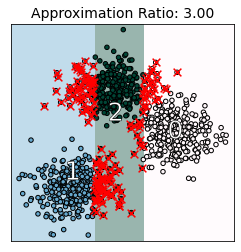

In [676]:
tree_char0 = Tree(k, valid_col_idx=[0])
tree_char0.tree = build_charikar_tree(x_data,kmeans.cluster_centers_,kmeans.labels_,0)
plot_tree_boundary(tree_char0, k, x_data, kmeans, plot_mistakes=True)

In [605]:
def get_mistakes(data, centers, assigned, feature, value):
    data_d = data[:,feature]
    centers_d = centers[:,feature]
    assign_d = centers_d[assigned]
    return sum([1 for i in zip(data_d, assign_d) if (i[0] - value) * (i[1] - value) < 0])

In [679]:
np.all(kmeans.predict(x_data) == kmeans.labels_)

True

In [624]:
get_mistakes(x_data, kmeans.cluster_centers_, kmeans.labels_, 1, tree_1d.tree.value)

25

In [613]:
c1 = kmeans.cluster_centers_[:,1].copy()
c1.sort()
assigns_1 = kmeans.cluster_centers_[kmeans.labels_,1]
sep1 = get_separations(x_data[:,1], c1, assigns_1)
sep1.sum(axis=0)

[-6.64282129  2.16602292  9.06349606] [-2.23839918  5.61475949]


array([25, 46])

In [690]:
km = KMeans(3)
km.fit(x)
if hasattr(km, 'labels_'):
    print(1)

1


In [636]:
# TODO: Check how to properly label the leaves
def add_labels(tree):
    nodes = [tree]
    label = 0
    while nodes:
        node = nodes.pop(0)
        if node.is_leaf():
            node.value = label
            label += 1
        else:
            if node.left:
                nodes.append(node.left)
            if node.right:
                nodes.append(node.right)

In [673]:
def get_separations(data, centers, assigns):
    mids = (centers[1:] + centers[:-1]) / 2
    print(centers, mids)
    above_d = np.array([find_first_above(d, mids) for d in data])
    above_c_dict = {c: find_first_above(c, mids) for c in centers}
    above_c = np.array([above_c_dict[a] for a in assigns])
    return np.array([[int( (i >= min(j)) and (i < max(j)) ) 
                         for i in range(len(mids))]
                        for j in zip(above_d, above_c)])    

def build_charikar_tree(data, centers, assigns, dim):
    data_d = data[:,dim].copy()
    centers_d = centers[:,dim].copy()
    centers_d.sort()
    idx_centers = centers[:,dim].argsort()
    centers_d = centers[:,dim][idx_centers]
    assigns_d = centers[assigns, dim]
    separated = get_separations(data_d, centers_d, assigns_d)
    costs = separated.sum(axis=0)
    tree = tree_with_costs(costs)
    print_tree(tree)
    print()
    tree_with_mids(tree,centers_d,idx_centers,dim)
    print_tree(tree)
    return tree

# def get_indices(x, y):
#     xsorted = np.argsort(x)
#     ypos = np.searchsorted(x[xsorted], y)
#     return xsorted[ypos]

def tree_with_costs(costs):
    if not len(costs):
        return
    min_cost = costs.min()
    if not min_cost:
        cut = costs.argmin()
        node = Node()
        node.value = cut
        node.left  = tree_with_costs(costs[:cut])
        node.right = tree_with_costs(costs[cut+1:])
        return node
    costs = costs / min_cost
    n = len(costs)
    j=1
    lc=rc=0
    t = np.ceil(np.log2(n)**(1/3))
    r = max(np.ceil(1 - 1/t), 2)
#     print(costs, j, lc, rc, r, t)
    return tree_with_pos_costs(costs,j,lc,rc,r,t,0)

def tree_with_pos_costs(costs,j,lc,rc,r,t,prev):
    print("infos:", costs, j, lc, rc, r, t)
    if not len(costs):
        print()
        return Node()
    min_cost = r**(j-1)
    max_cost = r**j
    mask = (costs >= min_cost) * (costs <= max_cost)
#     print("Step 1")
    while not np.any(mask):
#         print(min_cost, max_cost)
        j += 1
        min_cost = r**(j-1)
        max_cost = r**j
        mask = (costs >= min_cost) * (costs <= max_cost)
        lc = rc = 0 # TODO: isso fica na segunda versão?
    idx_mask = np.where(mask)[0]
    print("idx_mask:", idx_mask)
    
    add = 1
    if lc == t:
        lc = 0
        x_idx = idx_mask[0]
    elif rc == t:
        rc = 0
        x_idx = idx_mask[-1]
    else:
        add = 0
        m_start = idx_mask[0]
        m_end = idx_mask[-1]
        M = costs[m_start:m_end+1]
        print("M:", M)
        x_idx = (m_start + m_end) // 2
        print("initial x_idx:", x_idx)
        step = 0
        while not mask[x_idx]:
            step += 1
            x_idx += step
            if mask[x_idx]:
                break
            step += 1
            x_idx -= step
    
    node = Node()
    node.feature = x_idx + prev
    node.value = costs[x_idx]
    print("result:", node.feature, node.value)
    print()
    # TODO: check valores de lc e rc na segunda versão
    node.left  = tree_with_pos_costs(costs[:x_idx],1,lc+add,0,r,t,prev)
    node.right = tree_with_pos_costs(costs[x_idx+1:],1,0,rc+add,r,t,node.feature+1)
    return node

# def tree_with_mids(tree_with_costs,centers, dim):
#     mids = (centers[1:] + centers[:-1]) / 2
#     nodes = [tree_with_costs]
#     while nodes:
#         node = nodes.pop(0)
#         node.value = mids[node.feature]
#         node.feature = dim
#         if node.left:
#             nodes.append(node.left)
#         if node.right:
#             nodes.append(node.right)

def tree_with_mids(tree,centers,indices,dim):
    mids = (centers[1:] + centers[:-1]) / 2
    nodes = [(None, None, tree)]
    while nodes:
        cut, side, node = nodes.pop(0)
        if node.left:
            nodes.append((node.feature, "left", node.left))
            nodes.append((node.feature, "right", node.right))
            node.value = mids[node.feature]
            node.feature = dim
        elif side == "left":
            node.value = indices[cut]
        else:
            node.value = indices[cut+1]

def print_tree(tree):
    nodes = [(-1, tree)]
    i = 0
    while nodes:
        parent, node = nodes.pop(0)
        print(i, parent, node.feature, node.value)
        if node.left:
            nodes.append((i, node.left))
        if node.right:
            nodes.append((i, node.right))
        i += 1

In [600]:
# def find_first_above(val, seq):
#     if not len(seq):
#         return 0
#     elif len(seq) == 1:
#         return int(val >= seq[0])
#     mid = len(seq) // 2
#     if seq[mid] > val:
#         if seq[mid-1] <= val:
#             return mid
#         else:
#             return find_first_above(val, seq[:mid])
#     elif seq[mid+1] > val:
#         return mid + 1
#     else:
#         return mid + 1 + find_first_above(val, seq[mid+1:])

def find_first_above(val, seq):
    if not len(seq):
        return 0
    elif len(seq) == 1:
        return int(val >= seq[0])
    mid = len(seq) // 2
    if seq[mid] > val:
        return ffa(val, seq[:mid])
    else:
        return mid + 1 + ffa(val, seq[mid+1:])    

def test_ffa(n_tests):
    e = [0] * 3
    for i in range(n_tests):
        j = np.random.randint(1,20,size=1)[0]
        s = np.random.choice(np.arange(100),j, replace=False)
        s.sort()
        v = np.random.randint(100)
        n = find_first_above(v,s)
#         n = ffa(v,s)
        # s, v, find_first_above(v, s)
        if (0 < n) and (n < len(s)):
            if not( (s[n] > v) and (s[n-1] <= v) ):
                print(i, s, v, n)
                e[0] += 1
        elif n:
            if s[n-1] > v:
                print(i, s, v, n)
                e[1] += 1
        else:
            if s[n] <= v:
                print(i, s, v, n)
                e[2] += 1
    return e

test_ffa(100000)

[0, 0, 0]

In [559]:
tree_1d = Tree(k, valid_col_idx=[1])
tree_1d.fit(x_data, kmeans)
print_tree(tree_1d.tree)            

0 -1 1 -2.4418323617521667
1 0 None 1
2 0 1 5.699985026065612
3 2 None 0
4 2 None 2


In [663]:
argc1 = kmeans.cluster_centers_[:,1].argsort()
c1 = kmeans.cluster_centers_[:,1][argc1]
argc1, kmeans.cluster_centers_[:,1], c1
argc1, get_indices(kmeans.cluster_centers_[:,1], c1)

(array([1, 0, 2]), array([1, 0, 2]))

In [672]:
a = np.random.randint(100, size=20)
print(a)
arga = a.argsort()
print(arga)
sa = a[arga]
print(sa)
print(get_indices(a,sa))

[65 62 87 65 85 73 38 71 53 57 76 89  3 96 41 28 70 25 57 54]
[12 17 15  6 14  8 19 18  9  1  3  0 16  7  5 10  4  2 11 13]
[ 3 25 28 38 41 53 54 57 57 62 65 65 70 71 73 76 85 87 89 96]
[12 17 15  6 14  8 19 18 18  1  3  3 16  7  5 10  4  2 11 13]


In [674]:
tree_c1 = build_charikar_tree(x_data,kmeans.cluster_centers_,kmeans.labels_,1)

[-6.64282129  2.16602292  9.06349606] [-2.23839918  5.61475949]
infos: [1.   1.84] 1 0 0 2 1.0
idx_mask: [0 1]
M: [1.   1.84]
initial x_idx: 0
result: 0 1.0

infos: [] 1 0 0 2 1.0

infos: [1.84] 1 0 0 2 1.0
idx_mask: [0]
M: [1.84]
initial x_idx: 0
result: 1 1.84

infos: [] 1 0 0 2 1.0

infos: [] 1 0 0 2 1.0

0 -1 0 1.0
1 0 None None
2 0 1 1.84
3 2 None None
4 2 None None

0 -1 1 -2.238399182541735
1 0 None 1
2 0 1 5.614759492836358
3 2 None 0
4 2 None 2


In [65]:
def find_optimal_tree_1d(a, b, d, node_list, data_d, centers_d, assigns_d):
    if a == b:
        return 0
    mid_vals = np.array([(centers_d[j+1] - centers_d[j]) / 2 
                         for j in range(a, b-1)])
    results = np.array([number_errors_1d(val, data_d, assigns_d) 
                        for val in mid_vals])
    best_result = np.inf
    best_cut = 0
    for j in range(a, b-1):
        val = (centers_d[j+1] - centers_d[j]) / 2
        n_errors = number_errors_1d(val, data_d, assigns_d)
        
        left_data_mask = data_d 
    
    return min([number_errors(node_list[j].feature, node_list[j].value, 
                              data, centers, assignment)*(centers[b][i] - centers[a][i]) + 
                find_optimal_trees(a, j, i, node_list, data, centers, assignment) +
                find_optimal_trees(j+1, b, i, node_list, data, centers, assignment)
                for j in range(a,b)])

def number_errors_1d(value, data, assigns):
    ans = 0
    for i in range(len(data)):
        n_above = 1 if (data[i] > value) else 0
        if assigns[i] > value:
            n_above += 1
        if n_above == 1:
            ans += 1
    return ans

def find_best_cut(data, d, centers, assignment):
    best_val = 0
    for i in range(len(centers)-1):

In [108]:
kmeans.cluster_centers_
c0d = kmeans.cluster_centers_[:,0].copy()
c0d.sort()
(c0d[0] + c0d[1]) / 2

data_d = x_data[:,0].copy()
assigns_d = kmeans.cluster_centers_[kmeans.labels_, 0]

(array([-6.84696555, -2.59881762,  4.84710315]),
 array([[ 4.84710315,  2.16602292],
        [-6.84696555, -6.64282129],
        [-2.59881762,  9.06349606]]))

In [43]:
t = tree_1k.tree
tree_list = []
nodes = [(t, -1)]
i = 0
while nodes:
    nxt, parent = nodes.pop(0)
    tree_list.append((nxt.feature, nxt.value, parent))
    if nxt.left:
        nodes.append((nxt.left,i))
    if nxt.right:
        nodes.append((nxt.right,i))
    i += 1
    

In [44]:
tree_list

[(0, 0.4938371823571117, -1),
 (0, -5.0243887611280025, 0),
 (None, 0, 0),
 (None, 1, 1),
 (None, 2, 1)]

In [ ]:
e = np.zeros((n+1,n))
w = np.zeros((n+1,n))

for l in range(n):
    for i in range(n-l+2):
        j = i + l
        e[i,j] = np.inf
        w[i,j] = w[i,j-1] + p[j]
        for r in range(i,j+1):
            t = e[i,r-1] + e[r+1,j] + w[i,j]
            if t < e[i,j]:
                e[i,j] = t
                root[i,j] = r

In [208]:
n = 10000
d = 2
k = 10
x, _ = make_blobs(n, d, centers=k, cluster_std=2.5, random_state=42, center_box = [-10,10])

kmeans = KMeans(k)

%time kmeans.fit(x)

c0 = kmeans.cluster_centers_[:,0].copy()
x0 = x[:,0].copy()
c0.sort()
diffs = c0[1:] - c0[:-1]
mids = (c0[:-1] + c0[1:]) / 2
norm_diffs = diffs / min(diffs)

CPU times: user 2.01 s, sys: 56.7 ms, total: 2.07 s
Wall time: 621 ms


In [209]:
center_pos_at_d = kmeans.cluster_centers_[kmeans.labels_,0]
separated = np.zeros((len(x), len(mids)), dtype=int)
for i in range(len(mids)):
    mid = mids[i]
    for j in range(len(x)):
        n_above = int(x[j,0] > mid)
        if center_pos_at_d[j] > mid:
            n_above += 1
        if n_above == 1:
            separated[j,i] = 1

In [210]:
sep_sums = separated.sum(axis=0)
sep_sums / sep_sums.min()

array([1.92871287, 2.34455446, 2.41386139, 1.32673267, 2.43960396,
       2.20594059, 1.        , 1.14059406, 1.35049505])

In [644]:
c_sorted = np.argsort(kmeans.cluster_centers_[:,0])
c0, c_sorted, kmeans.cluster_centers_[:,0]

(array([-6.84696555, -2.59881762,  4.84710315]),
 array([1, 2, 0]),
 array([ 4.84710315, -6.84696555, -2.59881762]))

In [640]:
c0 = kmeans.cluster_centers_[:,0].copy()
c0.sort()
c0, kmeans.cluster_centers_

(array([-6.84696555, -2.59881762,  4.84710315]),
 array([[ 4.84710315,  2.16602292],
        [-6.84696555, -6.64282129],
        [-2.59881762,  9.06349606]]))

In [647]:
indices = c_sorted[np.searchsorted(kmeans.cluster_centers_[:,0][c_sorted],c0)]

array([1, 2, 0])

In [548]:
tree_0 = build_charikar_tree(x,kmeans.cluster_centers_,kmeans.labels_,0)

infos: [1.92871287 2.34455446 2.41386139 1.32673267 2.43960396 2.20594059
 1.         1.14059406 1.35049505] 1 0 0 2 2.0
idx_mask: [0 3 6 7 8]
M: [1.92871287 2.34455446 2.41386139 1.32673267 2.43960396 2.20594059
 1.         1.14059406 1.35049505]
initial x_idx: 4
result: 3 1.3267326732673268

infos: [1.92871287 2.34455446 2.41386139] 1 0 0 2 2.0
idx_mask: [0]
M: [1.92871287]
initial x_idx: 0
result: 0 1.9287128712871286

infos: [] 1 0 0 2 2.0

infos: [2.34455446 2.41386139] 1 0 0 2 2.0
idx_mask: [0 1]
M: [2.34455446 2.41386139]
initial x_idx: 0
result: 1 2.3445544554455444

infos: [] 1 0 0 2 2.0

infos: [2.41386139] 1 0 0 2 2.0
idx_mask: [0]
M: [2.41386139]
initial x_idx: 0
result: 2 2.413861386138614

infos: [] 1 0 0 2 2.0

infos: [] 1 0 0 2 2.0

infos: [2.43960396 2.20594059 1.         1.14059406 1.35049505] 1 0 0 2 2.0
idx_mask: [2 3 4]
M: [1.         1.14059406 1.35049505]
initial x_idx: 3
result: 7 1.1405940594059405

infos: [2.43960396 2.20594059 1.        ] 1 0 0 2 2.0
idx_mask

In [532]:
c0 = kmeans.cluster_centers_[:,0].copy()
c0.sort()
mids = (c0[1:] + c0[:-1]) / 2
mids

array([-9.45317319, -7.92664298, -6.92885132, -4.76049704, -2.64157981,
       -1.7093643 ,  0.75514579,  3.83383213,  6.12096435])

In [534]:
seps = get_separations(x,c0,c0[kmeans.labels_])
seps

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [522]:
nodes = [(-1, tree_0)]
i = 0
while nodes:
    parent, node = nodes.pop(0)
    print(i, parent, node.feature, node.value)
    if node.left:
        nodes.append((i, node.left))
    if node.right:
        nodes.append((i, node.right))
    i += 1

0 -1 0 [-3.87195421  7.76537336]
1 0 0 [-5.07230699  0.77794187]
2 0 0 [-1.74738685  3.39304434]
3 1 0 [-0.05829178 -7.02227001]
4 2 0 [ 2.03916466 -2.02040929]
5 2 0 [-5.49591581  3.57362576]
6 3 0 [-1.58482199  2.05699823]
7 4 0 [-2.03361405  1.16390188]
8 7 0 [-3.82828153 -4.10375563]


In [449]:
a = np.zeros(5)
a[0] = 2
a[3] = 4
a[4] = 2
b = (a == 2) * (a != 4)
np.where(b)[0]

(2,)

In [464]:
sep_sums = sep_sums / min(sep_sums)
sep_sums

array([2.35230352, 2.43089431, 2.43631436, 1.        , 2.62330623,
       1.17073171, 2.17615176, 1.21409214, 2.63414634])

In [515]:
n = tree_with_costs(sep_sums)

[2.35230352 2.43089431 2.43631436 1.         2.62330623 1.17073171
 2.17615176 1.21409214 2.63414634] 1 0 0 2 2.0


In [485]:
n.value, n.left.value, n.left.left.value, n.left.left.left.value, 

(5, 3, 1, 0, None)

In [507]:
nodes = [(-1, n)]
i = 0
while nodes:
    parent, node = nodes.pop(0)
    print(i, parent, node.feature, "{:.2f}".format(node.value))
    if node.left:
        nodes.append((i, node.left))
    if node.right:
        nodes.append((i, node.right))
    i += 1

0 -1 5 1.17
1 0 3 1.00
2 0 7 1.21
3 1 1 2.43
4 1 4 2.62
5 2 6 2.18
6 2 8 2.63
7 3 0 2.35
8 3 2 2.44


In [418]:
sep_sums = sep.sum(axis=0)
sep_sums / sep_sums.min()

array([2.35230352, 2.43089431, 2.43631436, 1.        , 2.62330623,
       1.17073171, 2.17615176, 1.21409214, 2.63414634])

In [512]:
sep.sum(axis=0), mids

(array([868, 897, 899, 369, 968, 432, 803, 448, 972]),
 array([-7.02227001, -5.55533828, -4.10375563, -1.00954426,  1.2543835 ,
         3.42782964,  5.56649048,  7.65832723,  9.85721011]))

In [516]:
nodes = [(-1, n)]
i = 0
while nodes:
    parent, node = nodes.pop(0)
    print(i, parent, node.feature, "{:.2f}".format(node.value))
    if node.left:
        nodes.append((i, node.left))
    if node.right:
        nodes.append((i, node.right))
    node.value = mids[node.feature]
    node.feature = 0
    print(i, parent, node.feature, "{:.2f}".format(node.value))
    print()
    i += 1

0 -1 5 1.17
0 -1 0 3.43

1 0 3 1.00
1 0 0 -1.01

2 0 7 1.21
2 0 0 7.66

3 1 1 2.43
3 1 0 -5.56

4 1 4 2.62
4 1 0 1.25

5 2 6 2.18
5 2 0 5.57

6 2 8 2.63
6 2 0 9.86

7 3 0 2.35
7 3 0 -7.02

8 3 2 2.44
8 3 0 -4.10



In [409]:
c1 = kmeans.cluster_centers_[:,1].copy()
c1.sort()
sep = get_separations(x[:,1], c1, kmeans.cluster_centers_[kmeans.labels_,1])

In [411]:
# todo: test separations
mids = (c1[1:] + c1[:-1]) / 2
for i in range(len(x)):
    d = x[i,1]
    c = kmeans.cluster_centers_[kmeans.labels_[i], 1]
    for j in range(len(mids)):
        mid = mids[j]
        result = not(all([k <= mid for k in [d,c]]) or all([k > mid for k in [d,c]]))
        if result != bool(sep[i,j]):
            print(i,j)

In [382]:
for i in range(10):
    print(separations[i], above_d[i], above_c[i])

[0 0 0 0 1 0 0 0 0] 4 5
[0 0 0 0 0 0 0 0 1] 9 8
[0 0 0 0 1 0 0 0 0] 4 5
[1 0 0 0 0 0 0 0 0] 0 1
[0 0 0 0 0 0 0 0 0] 0 0
[0 0 1 0 0 0 0 0 0] 3 2
[0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 0 0 1 0 0] 6 7
[0 0 0 0 0 0 1 0 0] 7 6
[0 0 0 0 0 0 0 1 0] 7 8


In [374]:
above_d = np.array([find_first_above(d, mids) for d in data_d])
centers_d = kmeans.cluster_centers_[kmeans.labels_,0]
above_c = np.array([find_first_above(c, mids) for c in centers_d])

In [373]:
list(zip(range(len(above_d)),above_d,above_c))

[(0, 4, 5),
 (1, 9, 8),
 (2, 4, 5),
 (3, 0, 1),
 (4, 0, 0),
 (5, 3, 2),
 (6, 4, 4),
 (7, 6, 7),
 (8, 7, 6),
 (9, 7, 8),
 (10, 3, 2),
 (11, 2, 2),
 (12, 1, 0),
 (13, 3, 2),
 (14, 8, 7),
 (15, 4, 5),
 (16, 7, 7),
 (17, 5, 5),
 (18, 0, 0),
 (19, 6, 5),
 (20, 6, 7),
 (21, 0, 1),
 (22, 4, 5),
 (23, 9, 9),
 (24, 2, 2),
 (25, 7, 7),
 (26, 3, 4),
 (27, 0, 1),
 (28, 3, 4),
 (29, 9, 9),
 (30, 9, 9),
 (31, 7, 8),
 (32, 5, 4),
 (33, 7, 8),
 (34, 9, 8),
 (35, 3, 2),
 (36, 2, 1),
 (37, 4, 6),
 (38, 9, 9),
 (39, 7, 7),
 (40, 6, 4),
 (41, 2, 0),
 (42, 3, 3),
 (43, 9, 8),
 (44, 9, 7),
 (45, 0, 1),
 (46, 3, 2),
 (47, 9, 8),
 (48, 8, 8),
 (49, 3, 4),
 (50, 6, 6),
 (51, 7, 7),
 (52, 6, 6),
 (53, 4, 3),
 (54, 6, 7),
 (55, 5, 6),
 (56, 3, 1),
 (57, 0, 0),
 (58, 6, 4),
 (59, 7, 6),
 (60, 6, 4),
 (61, 8, 9),
 (62, 2, 3),
 (63, 0, 0),
 (64, 3, 1),
 (65, 3, 2),
 (66, 7, 5),
 (67, 2, 0),
 (68, 4, 4),
 (69, 5, 6),
 (70, 1, 2),
 (71, 3, 2),
 (72, 8, 7),
 (73, 8, 9),
 (74, 8, 8),
 (75, 1, 0),
 (76, 8, 8),
 (77, 1, 

In [368]:
for i in range(10):
    print(above_d[i], above_c[i])

4 5
9 8
4 5
0 1
0 0
3 2
4 4
6 7
7 6
7 8


In [598]:
s = np.random.choice(np.arange(100),10, replace=False)
s.sort()
s, np.random.randint(1,20,size=1)[0]

(array([ 3, 18, 22, 30, 42, 48, 52, 77, 83, 84]), 1)

In [309]:
print(mids)
for i in range(10):
    d = x[i][0]
    a = kmeans.labels_[i]
    c = kmeans.cluster_centers_[a,0]
    nd = find_first_above(d, mids)
    nc = find_first_above(c, mids)
    print("{:.2f}\t{:.2f}\t".format(d, c), nd, nc, separated[i])

# find_first_above(x[0][0], mids), find_first_above(kmeans.cluster_centers_[, 0], mids)

[-9.45317319 -7.92664298 -6.92885132 -4.76049704 -2.64157981 -1.7093643
  0.75514579  3.83383213  6.12096435]
-3.59	-2.38	 4 5 [0 0 0 0 1 0 0 0 0]
7.04	5.12	 9 8 [0 0 0 0 0 0 0 0 1]
-4.28	-2.38	 4 5 [0 0 0 0 1 0 0 0 0]
-9.45	-8.61	 0 1 [1 0 0 0 0 0 0 0 0]
-10.37	-10.29	 0 0 [0 0 0 0 0 0 0 0 0]
-6.21	-7.24	 3 2 [0 0 1 0 0 0 0 0 0]
-3.31	-2.90	 4 4 [0 0 0 0 0 0 0 0 0]
0.27	2.55	 6 7 [0 0 0 0 0 0 1 0 0]
0.87	-1.04	 7 6 [0 0 0 0 0 0 1 0 0]
1.54	5.12	 7 8 [0 0 0 0 0 0 0 1 0]


In [251]:
s = np.random.choice(np.arange(100),10, replace=False)
s.sort()
v = np.random.randint(100)
n = find_first_above(v,s)
if n:
    print(s[n] > v and s[n-1] <= v)

[24 45 58 66 67 78 79 84 88 98] 10
[24 45 58 66 67] 5
[24 45] 2
[24] 1
[] 0
False


In [254]:
if (0 < n) and (n < len(s)):
    print(s[n] > v and s[n-1] <= v)
elif n:
    print(s[n-1] <= v)
else:
    print(s[n] > v)

True


In [259]:
find_first_above(97,s)

[24 45 58 66 67 78 79 84 88 98] 10
[79 84 88 98] 4


9